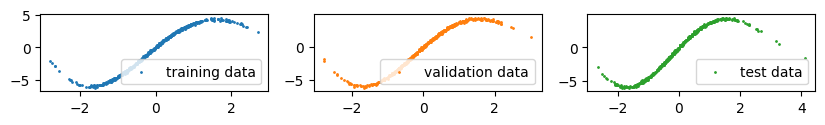

In [29]:
import numpy as np
import matplotlib.pyplot as plt


def make_sinusoidal(n_data: int, noise: float = 0.1, seed: int = 0):
    np.random.seed(seed)
    w = np.arange(30)[:, None] / 30
    b = 2 * np.pi * np.arange(30)[:, None] / 30

    x = np.random.normal(size=(n_data,))
    y = np.cos(w * x + b).sum(0) + noise * np.random.normal(size=(n_data,))
    return x[:, None], y[:, None]


train_data = make_sinusoidal(n_data=500, seed=0)
val_data = make_sinusoidal(n_data=500, seed=1)
test_data = make_sinusoidal(n_data=500, seed=2)

fig, axes = plt.subplots(1, 3, figsize=(10, 1))
axes[0].scatter(*train_data, s=1, label="training data", c="C0")
axes[0].legend()
axes[1].scatter(*val_data, s=1, label="validation data", c="C1")
axes[1].legend()
axes[2].scatter(*test_data, s=1, label="test data", c="C2")
axes[2].legend()

In [30]:
from fortuna.data import DataLoader

train_data_loader = DataLoader.from_array_data(
    train_data, batch_size=128, shuffle=True, prefetch=True
)
val_data_loader = DataLoader.from_array_data(val_data, batch_size=128, prefetch=True)
test_data_loader = DataLoader.from_array_data(test_data, batch_size=128, prefetch=True)

In [31]:
from fortuna.prob_model import ProbRegressor, DeepEnsemblePosteriorApproximator
from fortuna.model import MLP
import flax.linen as nn

output_dim = 1
prob_model = ProbRegressor(
    model=MLP(output_dim=output_dim, activations=(nn.tanh, nn.tanh)),
    likelihood_log_variance_model=MLP(
        output_dim=output_dim, activations=(nn.tanh, nn.tanh)
    ),
    posterior_approximator=DeepEnsemblePosteriorApproximator(),
)

In [32]:
from fortuna.prob_model import FitConfig, FitMonitor, CalibConfig, CalibMonitor
from fortuna.metric.regression import rmse

status = prob_model.train(
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    calib_data_loader=val_data_loader,
    fit_config=FitConfig(
        monitor=FitMonitor(early_stopping_patience=2, metrics=(rmse,))
    ),
    calib_config=CalibConfig(monitor=CalibMonitor(early_stopping_patience=2)),
)

Epoch: 100 | loss: 1801.01233 | rmse: 0.34807: 100%|██████████| 100/100 [00:02<00:00, 35.30it/s]
Epoch: 100 | loss: 1750.73816 | rmse: 0.29804: 100%|██████████| 100/100 [00:01<00:00, 83.89it/s]
Epoch: 100 | loss: 1840.17017 | rmse: 0.37487: 100%|██████████| 100/100 [00:01<00:00, 87.37it/s]
Epoch: 100 | loss: 1830.52954 | rmse: 0.35051: 100%|██████████| 100/100 [00:01<00:00, 77.28it/s]
Epoch: 100 | loss: 1798.47156 | rmse: 0.32457: 100%|██████████| 100/100 [00:01<00:00, 75.53it/s]
Epoch: 15 | loss: -183.82832:  14%|█▍        | 14/100 [00:01<00:07, 11.15it/s]


Text(0.5, 1.0, 'loss decays')

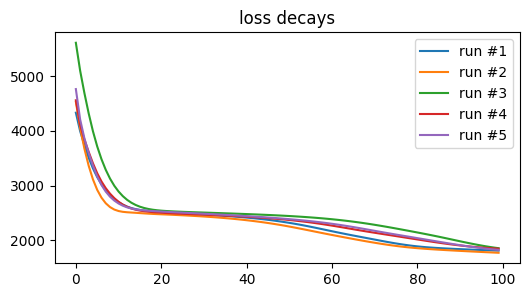

In [33]:
plt.figure(figsize=(6, 3))
for i, s in enumerate(status["fit_status"]):
    plt.plot(s["loss"], label=f"run #{i+1}")
plt.legend()
plt.title("loss decays", fontsize=12)

In [34]:
test_log_probs = prob_model.predictive.log_prob(data_loader=test_data_loader)
test_inputs_loader = test_data_loader.to_inputs_loader()
test_means = prob_model.predictive.mean(inputs_loader=test_inputs_loader)
test_aleatoric_variances = prob_model.predictive.aleatoric_variance(
    inputs_loader=test_inputs_loader
)
test_epistemic_variances = prob_model.predictive.epistemic_variance(
    inputs_loader=test_inputs_loader
)
test_variances = prob_model.predictive.variance(
    inputs_loader=test_inputs_loader,
    aleatoric_variances=test_aleatoric_variances,
    epistemic_variances=test_epistemic_variances,
)
test_stds = prob_model.predictive.std(
    inputs_loader=test_inputs_loader, variances=test_variances
)
test_cred_intervals = prob_model.predictive.credible_interval(
    inputs_loader=test_inputs_loader
)

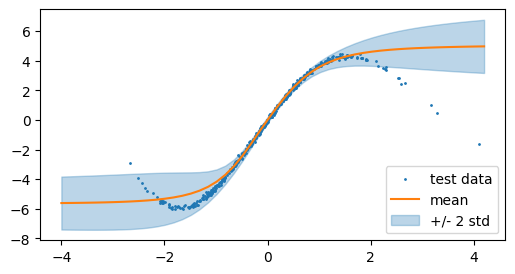

In [35]:
from fortuna.data import InputsLoader

mesh = np.linspace(-4, 4.2)
mesh_loader = InputsLoader.from_array_inputs(mesh)
mesh_mean = prob_model.predictive.mean(mesh_loader)
mesh_std = prob_model.predictive.std(mesh_loader)
plt.figure(figsize=(6, 3))
plt.scatter(*test_data, s=1, color="C0", label="test data")
plt.plot(mesh, mesh_mean, color="C1", label="mean")
plt.fill_between(
    mesh,
    (mesh_mean - 2 * mesh_std).squeeze(1),
    (mesh_mean + 2 * mesh_std).squeeze(1),
    alpha=0.3,
    color="C0",
    label=f"+/- {2} std",
)
plt.legend(loc="lower right")

In [36]:
from fortuna.metric.regression import (
    root_mean_squared_error,
    prediction_interval_coverage_probability,
)

test_targets = test_data_loader.to_array_targets()
rmse = root_mean_squared_error(preds=test_means, targets=test_targets)
cred_picp = prediction_interval_coverage_probability(
    lower_bounds=test_cred_intervals[:, 0],
    upper_bounds=test_cred_intervals[:, 1],
    targets=test_targets,
)
print(f"Test RMSE: {rmse}")
print(f"PICP for 95% credible intervals of test inputs: {cred_picp}")

Test RMSE: 0.5550875067710876
PICP for 95% credible intervals of test inputs: 0.9300000667572021


In [37]:
from fortuna.conformal import QuantileConformalRegressor

val_inputs_loader = val_data_loader.to_inputs_loader()
val_cred_intervals = prob_model.predictive.credible_interval(
    inputs_loader=val_inputs_loader
)
test_conformal_intervals = QuantileConformalRegressor().conformal_interval(
    val_lower_bounds=val_cred_intervals[:, 0],
    val_upper_bounds=val_cred_intervals[:, 1],
    test_lower_bounds=test_cred_intervals[:, 0],
    test_upper_bounds=test_cred_intervals[:, 1],
    val_targets=val_data_loader.to_array_targets(),
    error=0.05,
)
conformal_picp = prediction_interval_coverage_probability(
    lower_bounds=test_conformal_intervals[:, 0],
    upper_bounds=test_conformal_intervals[:, 1],
    targets=test_targets,
)
print(f"PICP for 95% conformal intervals of test inputs: {conformal_picp}")

PICP for 95% conformal intervals of test inputs: 0.9340000152587891


In [38]:
from fortuna.conformal import OneDimensionalUncertaintyConformalRegressor

val_means = prob_model.predictive.mean(inputs_loader=val_inputs_loader)
val_stds = prob_model.predictive.std(inputs_loader=val_inputs_loader)

test_conformal_intervals2 = (
    OneDimensionalUncertaintyConformalRegressor().conformal_interval(
        val_preds=val_means,
        val_uncertainties=val_stds,
        test_preds=test_means,
        test_uncertainties=test_stds,
        val_targets=val_data_loader.to_array_targets(),
        error=0.05,
    )
)
conformal_picp2 = prediction_interval_coverage_probability(
    lower_bounds=test_conformal_intervals2[:, 0],
    upper_bounds=test_conformal_intervals2[:, 1],
    targets=test_targets,
)
print(f"PICP for 95% conformal intervals of test inputs: {conformal_picp2}")

PICP for 95% conformal intervals of test inputs: 0.9260000586509705


# Use model outputs

In [39]:
prob_model.predictive.variance(val_inputs_loader).shape

(500, 1)

In [40]:
test_means

Array([[-2.08717155e+00],
       [-2.71323085e-01],
       [-5.39980125e+00],
       [ 4.38862896e+00],
       [-5.23679495e+00],
       [-3.78076243e+00],
       [ 2.19001389e+00],
       [-4.68109035e+00],
       [-4.33627844e+00],
       [-3.97426414e+00],
       [ 2.36266160e+00],
       [ 4.71572638e+00],
       [ 2.05291778e-01],
       [-4.45878696e+00],
       [ 2.31937909e+00],
       [-2.89835882e+00],
       [-8.87168422e-02],
       [ 3.87628150e+00],
       [-3.47661090e+00],
       [ 4.83875312e-02],
       [-3.88782597e+00],
       [-7.73697972e-01],
       [ 1.19741559e+00],
       [-4.17895651e+00],
       [-1.70248652e+00],
       [-1.18080533e+00],
       [-3.06708837e+00],
       [-4.58638430e+00],
       [-4.91820574e+00],
       [-7.58777857e-01],
       [-1.34885526e+00],
       [ 4.69586468e+00],
       [-5.48621893e+00],
       [ 5.43277681e-01],
       [ 1.67920709e+00],
       [ 4.12268257e+00],
       [ 2.18628621e+00],
       [-3.78821158e+00],
       [ 4.6

In [41]:
import numpy as np

calib_outputs = np.concatenate(
    (val_means, np.log(prob_model.predictive.variance(val_inputs_loader))), axis=-1
)
test_outputs = np.concatenate((test_means, np.log(test_variances)), axis=-1)

calib_targets = val_data_loader.to_array_targets()
test_targets = test_data_loader.to_array_targets()

In [42]:
len(test_targets)

500

In [43]:
test_variances

Array([[0.02430564],
       [0.0105347 ],
       [0.8015511 ],
       [0.13218646],
       [0.67836857],
       [0.11132967],
       [0.01199201],
       [0.33798724],
       [0.21703045],
       [0.13930425],
       [0.01295484],
       [0.30196932],
       [0.00953372],
       [0.25362018],
       [0.01269238],
       [0.04564512],
       [0.01005048],
       [0.05223177],
       [0.07988913],
       [0.00977291],
       [0.12587862],
       [0.01253051],
       [0.00935026],
       [0.17837398],
       [0.01920521],
       [0.01482205],
       [0.05323203],
       [0.2989265 ],
       [0.4593767 ],
       [0.01245853],
       [0.01600675],
       [0.28514224],
       [0.85610193],
       [0.0092328 ],
       [0.01016608],
       [0.07809544],
       [0.01197505],
       [0.1122657 ],
       [0.00985403],
       [0.01275916],
       [0.01791891],
       [0.02013695],
       [0.71172136],
       [0.15312755],
       [0.09687581],
       [0.01903785],
       [0.01441129],
       [0.009

In [44]:
from fortuna.output_calib_model import OutputCalibRegressor, Config, Monitor

calib_model = OutputCalibRegressor()
calib_status = calib_model.calibrate(
    calib_outputs=calib_outputs,
    calib_targets=calib_targets,
    config=Config(monitor=Monitor(early_stopping_patience=2)),
)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 100 | loss: -2.35092: 100%|██████████| 100/100 [00:00<00:00, 180.79it/s]


In [45]:
test_log_probs = calib_model.predictive.log_prob(
    outputs=test_outputs, targets=test_targets
)
test_means = calib_model.predictive.mean(outputs=test_outputs)
test_variances = calib_model.predictive.variance(outputs=test_outputs)
test_stds = calib_model.predictive.std(outputs=test_outputs, variances=test_variances)
test_cred_intervals = calib_model.predictive.credible_interval(outputs=test_outputs)

In [46]:
test_variances

Array([[0.02178044],
       [0.00944021],
       [0.71827507],
       [0.11845314],
       [0.60789037],
       [0.09976321],
       [0.01074611],
       [0.30287254],
       [0.19448237],
       [0.12483143],
       [0.01160891],
       [0.27059662],
       [0.00854323],
       [0.22727066],
       [0.01137372],
       [0.04090289],
       [0.0090063 ],
       [0.04680523],
       [0.07158917],
       [0.00875757],
       [0.11280062],
       [0.01122867],
       [0.00837882],
       [0.15984207],
       [0.01720991],
       [0.01328213],
       [0.04770156],
       [0.26786995],
       [0.4116504 ],
       [0.01116417],
       [0.01434375],
       [0.25551778],
       [0.7671584 ],
       [0.00827357],
       [0.00910988],
       [0.06998183],
       [0.01073091],
       [0.100602  ],
       [0.00883025],
       [0.01143357],
       [0.01605725],
       [0.01804485],
       [0.63777804],
       [0.13721858],
       [0.08681102],
       [0.01705994],
       [0.01291404],
       [0.008

In [47]:
val_means = prob_model.predictive.mean(inputs_loader=val_inputs_loader)
val_stds = prob_model.predictive.std(inputs_loader=val_inputs_loader)

test_conformal_intervals3 = (
    OneDimensionalUncertaintyConformalRegressor().conformal_interval(
        val_preds=val_means,
        val_uncertainties=val_stds,
        test_preds=test_means,
        test_uncertainties=test_stds,
        val_targets=val_data_loader.to_array_targets(),
        error=0.05,
    )
)
conformal_picp3 = prediction_interval_coverage_probability(
    lower_bounds=test_cred_intervals[:, 0],
    upper_bounds=test_cred_intervals[:, 1],
    targets=test_targets,
)
print(f"PICP for 95% conformal intervals of test inputs: {conformal_picp3}")

PICP for 95% conformal intervals of test inputs: 0.9100000262260437
